In [0]:
!pip install nagisa
!pip install pykakasi

In [0]:
pip install fasttext

# Import all Required Libraries

In [34]:
import nagisa
import pykakasi
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import io
import fasttext.util
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dropout,Embedding,Input,LSTM,GRU,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Function to Clean the Japanese Corpus

In [2]:
def clean_data(text):
    clean_text = text.lower() # converts any english word in lower case
    clean_text = re.sub(r"\W"," ",clean_text) # removing any non-words characters which include special characters, comma, punctuation
    clean_text = re.sub(r"\d"," ",clean_text) # removing any digits
    clean_text = re.sub(r"\s+",' ',clean_text) # removing any extra spaces in middle 
    clean_text = re.sub(r"^\s",' ',clean_text) # removing any extra spaces in beginning
    clean_text = re.sub(r"\s$",' ',clean_text) # removing any extra spaces in end
    return clean_text

# Function to create the Vocabulary Histogram
### This Function is latter used to filter the vocabulary

In [3]:
def get_vocabulary_histogram(clean_corpus_jp):
    vocabulary_count_dict = {}
    stop_words = jp_stopwords = ["あそこ","あっ","あの","あのかた","あの人","あり","あります","ある",
                                 "あれ","い","いう","います","いる","う","うち","え","お","および",
                                 "おり","おります","か","かつて","から","が","き","ここ","こちら",
                                 "こと","この","これ","これら","さ","さらに","し","しかし","する","ず",
                                 "せ","せる","そこ","そして","その","その他","その後","それ","それぞれ",
                                 "それで","た","ただし","たち","ため","たり","だ","だっ","だれ","つ","て",
                                 "で","でき","できる","です","では","でも","と","という","といった","とき",
                                 "ところ","として","とともに","とも","と共に","どこ","どの","な","ない",
                                 "なお","なかっ","ながら","なく","なっ","など","なに","なら","なり",
                                 "なる","なん","に","において","における","について","にて","によって",
                                 "により","による","に対して","に対する","に関する","の","ので","のみ",
                                 "は","ば","へ","ほか","ほとんど","ほど","ます","また","または","まで",
                                 "も","もの","ものの","や","よう","より","ら","られ","られる","れ","れる",
                                 "を","ん","何","及び","彼","彼女","我々","特に","私","私達","貴方","貴方方"]
    for x in tqdm(clean_corpus_jp):
        for token in nagisa.extract(x,extract_postags=['接頭辞','形容詞','名詞','動詞','助動詞','副詞','代名詞']).words:
            if token not in stop_words:
                if token not in vocabulary_count_dict.keys():
                    vocabulary_count_dict[token] = 1
                else:
                    vocabulary_count_dict[token] += 1
    return vocabulary_count_dict

# Loading the Japanese Corpus

In [5]:
f_negative = io.open("10000negative.txt", mode="r", encoding="utf-8")
f_positive = io.open("10000positive.txt", mode="r", encoding="utf-8")

In [6]:
negative_reviews = f_negative.readlines()
positive_reviews = f_positive.readlines()

In [7]:
positive_clean = []
negative_clean = []

for pos_text,neg_text in list(zip(positive_reviews,negative_reviews)):
  positive_clean.append(clean_data(pos_text))
  negative_clean.append(clean_data(neg_text))

In [8]:
corpus = positive_clean + negative_clean

# Create the Japanese Vocabulary Histogram

In [9]:
vocabulary_count_dict = get_vocabulary_histogram(corpus)

100%|██████████| 20000/20000 [48:24<00:00,  6.89it/s]  


In [10]:
vocab_count_dict_file = open(r"E:\Japanese Sentiment Analysis\Japanese Sentiment Analysis-1\vocab_count_dict.pkl", "wb")
pickle.dump(vocabulary_count_dict, vocab_count_dict_file)
vocab_count_dict_file.close()

In [11]:
vocab_count_dict_file = open(r"E:\Japanese Sentiment Analysis\Japanese Sentiment Analysis-1\vocab_count_dict.pkl", "rb")
vocabulary_count_dict = pickle.load(vocab_count_dict_file)

In [68]:
vocabulary_count_dict

{'アップル': 88,
 '信者': 4,
 'ずっと': 132,
 'tv': 733,
 '使用': 3825,
 'ました': 5977,
 'next': 10,
 'アマゾン': 507,
 'ビデオ': 612,
 '未': 59,
 '対応': 947,
 '商品': 3698,
 '購入': 6859,
 '比較': 260,
 'fire': 284,
 '優れ': 78,
 'ポイント': 125,
 'ミュージック': 51,
 '月額': 6,
 '円': 1064,
 'ホーム': 155,
 'シェアリング': 1,
 '要': 78,
 'pc': 1145,
 '起動': 265,
 'iphone': 467,
 'ワン': 39,
 'タッチ': 316,
 'ミラーリング': 99,
 '価格': 1531,
 '約': 196,
 '三': 94,
 '一': 1703,
 '快適': 246,
 '操作': 720,
 '視聴': 265,
 'プライム': 913,
 '得': 357,
 '感': 1187,
 'アプリ': 430,
 '量': 224,
 '結論': 60,
 '会員': 528,
 '場合': 565,
 '絶対': 185,
 '方': 2680,
 '機能': 693,
 'サービス': 197,
 '満喫': 6,
 'スマホ': 825,
 '専用': 160,
 '入れる': 280,
 '音声': 404,
 '認識': 1066,
 'リモコン': 594,
 '有り': 173,
 '無し': 192,
 '本体': 1162,
 '性能': 212,
 '変わり': 92,
 'なし': 641,
 '問題': 2658,
 '電話': 299,
 '光': 145,
 '換え': 158,
 '為': 428,
 'モデム': 14,
 '無線': 121,
 'lan': 156,
 'とても': 1743,
 '便利': 676,
 'インターネット': 68,
 '何処': 33,
 '使え': 1616,
 'くれ': 556,
 '音楽': 255,
 'パソコン': 638,
 'アルバム': 38,
 '自動': 171,
 '入っ': 1508,
 '呉れ':

# Download the Japanese Word2Vec from Fasttext

In [0]:
fasttext.util.download_model('ja', if_exists='ignore')

In [14]:
embedding = fasttext.load_model(r'E:\Google Word2Vec Pre-trained Model\cc.ja.300.bin')

# Filter the Japanese Vocabulary for each document

In [18]:
X = []

for x in tqdm(corpus):
  text = []
  tokens = x.split(" ")
  for token in tokens:
    if token in vocabulary_count_dict.keys():
      text.append(token)
  X.append(text)

100%|██████████| 20000/20000 [00:01<00:00, 18884.07it/s]


# Create the Embedding Matrix required to feed in Neural Network

In [21]:
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 100

In [22]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 12180 unique tokens.


In [23]:
EMBEDDING_DIM = embedding.get_dimension()

In [24]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

In [25]:
for word, i in word_index.items():
    embedding_vector = embedding.get_word_vector(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix_file = open(r"E:\Japanese Sentiment Analysis\Japanese Sentiment Analysis-1\embedding_matrix.pkl", "wb")
pickle.dump(embedding_matrix, embedding_matrix_file)
embedding_matrix_file.close()

# Prepare the Numerical Data and Split into Train-Test Dataset

In [28]:
y = np.array(list(np.ones([len(positive_clean)])) + list(np.zeros([len(negative_clean)])))

In [29]:
y_categorical = to_categorical(y)

In [30]:
y_categorical.shape

(20000, 2)

In [31]:
X_train,X_val,y_train,y_val = train_test_split(data,y_categorical,train_size=0.95,random_state=10)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,train_size=0.8,random_state=10)

# Create the Model using Embedding Matrix, GRU and Dense Layers

In [35]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)(inp)
x = Bidirectional(GRU(256, return_sequences=True))(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Bidirectional(GRU(32, return_sequences=True))(x)
avg_pl = GlobalAveragePooling1D()(x)
max_pl = GlobalMaxPooling1D()(x)
concat = concatenate([avg_pl, max_pl])
dense  = Dense(256, activation="relu")(concat)
dense  = Dense(128, activation="relu")(concat)
dense  = Dense(64, activation="relu")(concat)
drop   = Dropout(0.4)(concat)
output = Dense(2, activation="softmax")(concat)

In [44]:
model  = Model(inputs=inp, outputs=output)

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001,amsgrad=True), metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     3654300     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 512)     855552      embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 100, 256)     492288      bidirectional_5[0][0]            
____________________________________________________________________________________________

In [47]:
epochs = 50
batch_size = 10

# Define the Callbacks for Early Stopping and Model-Checkpoint

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
model_checkpoint = ModelCheckpoint('best_model__10000PositiveNegative.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Train the Model

In [49]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[X_val, y_val],verbose=4,callbacks=[early_stopping,model_checkpoint])

Train on 15200 samples, validate on 1000 samples
Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.86700, saving model to best_model__10000PositiveNegative.h5
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.86700 to 0.89500, saving model to best_model__10000PositiveNegative.h5
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.89500
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.89500 to 0.89800, saving model to best_model__10000PositiveNegative.h5
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.89800 to 0.90400, saving model to best_model__10000PositiveNegative.h5
Epoch 6/50

Epoch 00006: val_accuracy did not improve from 0.90400
Epoch 7/50

Epoch 00007: val_accuracy improved from 0.90400 to 0.90600, saving model to best_model__10000PositiveNegative.h5
Epoch 8/50

Epoch 00008: val_accuracy improved from 0.90600 to 0.91200, saving model to best_model__10000PositiveNegative.h5
Epoch 9/50

Epoch 00009: val_accuracy improved from 0.91200 to 0.92600

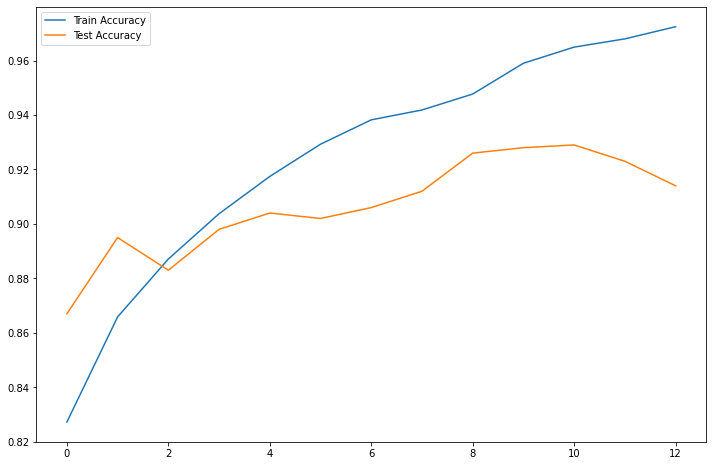

In [50]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

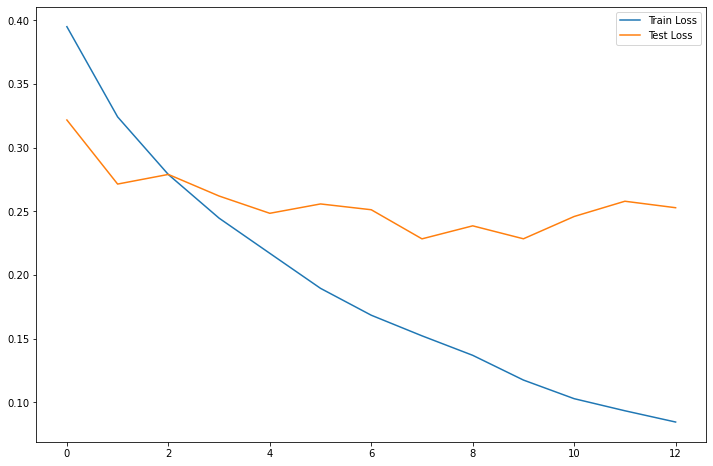

In [51]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

# Evaluating the Model

In [52]:
y_pred = model.predict(X_test)

In [53]:
y_pred = np.around(y_pred)

In [54]:
# accuracy: (tp + tn) / (p + n)
accuracy_score(y_test,y_pred)

0.9136842105263158

In [69]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.977, Test: 0.914


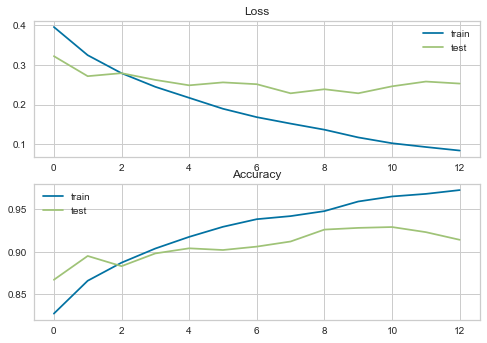

In [71]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [72]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [56]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
confusion_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

Confusion matrix, without normalization
[[1776  114]
 [ 214 1696]]


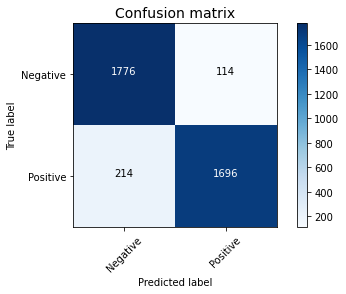

In [58]:
plot_confusion_matrix(confusion_matrix,classes=['Negative','Positive'])

In [78]:
# precision tp / (tp + fp)
precision = precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('Precision: %f' % precision)

Precision: 0.937017


In [79]:
# recall: tp / (tp + fn)
recall = recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('Recall: %f' % recall)

Recall: 0.887958


In [80]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('F1 score: %f' % f1)

F1 score: 0.911828


In [81]:
# kappa
kappa = cohen_kappa_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.827411


In [82]:
# ROC AUC
auc = roc_auc_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('ROC AUC: %f' % auc)

ROC AUC: 0.913820


In [83]:
report = classification_report(y_test,y_pred,output_dict=True)

In [84]:
classification_report_df = pd.DataFrame(report).transpose()

# Classification Report

In [100]:
format_dict = {'precision':'{0:,.2f}','recall':'{0:,.2f}','f1-score':'{0:,.2f}'}
classification_report_df.style.format(format_dict).background_gradient(subset=['precision','recall','f1-score'], cmap='hsv')

,precision,recall,f1-score,support
0,0.89,0.94,0.92,1890
1,0.94,0.89,0.91,1910
micro avg,0.91,0.91,0.91,3800
macro avg,0.91,0.91,0.91,3800
weighted avg,0.91,0.91,0.91,3800
samples avg,0.91,0.91,0.91,3800
